
### Feature Hypothesis : 

#### What are the expected reletionships of independent variables with review score?
1. order_items_qty ("+") - if consumer gets more than one item from the same seller, it should mean that he/she knows the quality of the good. Therefore, increase in item quantity should increase review score
2. product_description_lenght ("+") - buyer having more information about buying product should have positive relationship with review score
3. product_photos_qty ("+")
4. product_name_lenght ('unknown')- shorter names sometimes can be ambiguous or can be easy to understand,so relationship with review score is unknown at this point
5. delivery_accuracy ("+") - item coming on time or earlier that it was described should have positive relationship with review score
6. order_products_value ("-") - more expensive perhaps means better quality or higher expectation towards order fulfilment;
7. order_freight_value ("-") - more frieght means more expectation towards delivery accuracy


In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline 
import seaborn as sns
import datetime as dt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
#import calendar as cal
#import workalendar
from workalendar.america import Brazil
from datetime import date
from sklearn.cross_validation import train_test_split
%store -r orders_v2

C:\Users\R2D2\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
orders = orders_v2[['order_status', 'order_products_value',
                 'order_freight_value', 'order_items_qty', 'order_sellers_qty',
                 'order_purchase_timestamp', 'order_aproved_at', 'order_estimated_delivery_date', 
                 'order_delivered_customer_date', 'customer_state', 
                 'product_category_name', 'product_name_lenght', 'product_description_lenght', 
                 'product_photos_qty', 'review_score']]

In [3]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
order_status                     100000 non-null object
order_products_value             100000 non-null float64
order_freight_value              100000 non-null float64
order_items_qty                  100000 non-null int64
order_sellers_qty                100000 non-null int64
order_purchase_timestamp         100000 non-null datetime64[ns]
order_aproved_at                 99982 non-null datetime64[ns]
order_estimated_delivery_date    100000 non-null datetime64[ns]
order_delivered_customer_date    97595 non-null datetime64[ns]
customer_state                   100000 non-null object
product_category_name            100000 non-null object
product_name_lenght              100000 non-null int64
product_description_lenght       100000 non-null int64
product_photos_qty               100000 non-null int64
review_score                     100000 non-null int64
dtypes: datetime64[ns](4

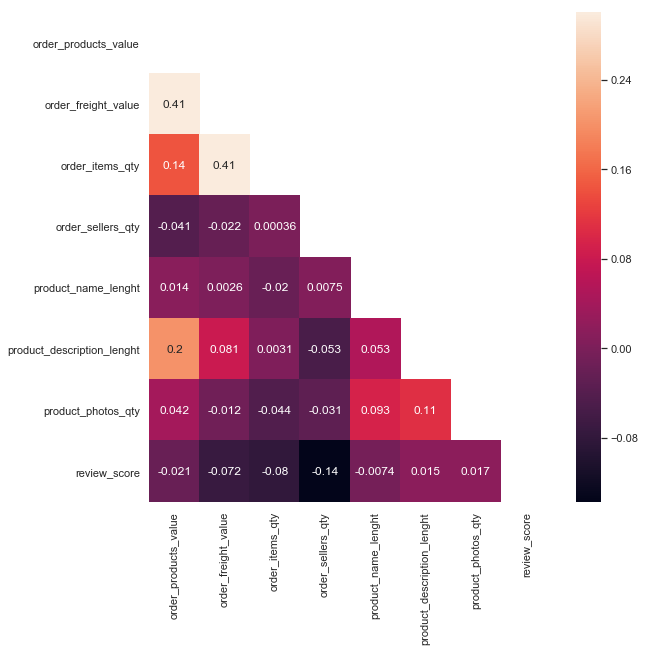

In [4]:
sns.set(font_scale=1)
corr = orders.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    plt.figure(figsize=(9,9))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, annot=True)

Most variables do have quite weak relationship with review score.Lets try fitting this is OLS regression. 

Let’s interpret the table.Overall the model is significiant.

__Prob(F-statistcs)__= 0.000 This is the p-value associated with the F-statistic(F(6,97588)= 1197). It is used in testing the null hypothesis that all of the model coefficients are 0. 

This tells us that there is a significant difference in the group means. 

__Coef.__ : These are the values for the regression equation for predicting the dependent variable from the independent variable. The regression equation is presented in many different ways, for example:

Ypredicted = b0 + b1*x1 + b2*x2 + b3*x3 + b4*x4

The column of estimates provides the values for b0, b1, b2, b3 and b4 for this equation. 

   __order_items_qty__:-0.2464	So for every unit increase in order item qianity, a 0.2464 unit decrease in review_score  is
                       predicted, holding all other variables constant. 

   __product_name_lenght__ :-0.0019	for every unit increase in product_name_lenght, a 0.0019 unit decrease in review_score 
                       is predicted, holding all other variables constant. 

   __product_description_lenght__ :4.038e-05 for every unit increase in product_description_lenght, a 4.038e-05 unit increase in
                       review_score  is predicted, holding all other variables constant.

   __product_photos_qty__ :	0.0106	for every unit increase in product_photos_qty, a 0.0106 unit increase in
                       review_score  is predicted, holding all other variables constant.
                       
   __order_delivery_before_estimated_date_in_days__: 0.0317	for every unit increase in order delivery accuracy, a 0.0317 unit 
                       increase in review_score  is predicted, holding all other variables constant.
               
   __order_products_value__ :-2.767e-05	for every unit increase in product_name_lenght, a 2.767e-05 unit decrease in 
                       review_score is predicted, holding all other variables constant. 


Looking at the __p-values__ :
__P>|t|__ – This column shows the 2-tailed p-values used in testing the null hypothesis that the coefficient (parameter) is 0.   Using an alpha of 0.05:

   The coefficient for all the variables is significantly different from 0 because their p-value is 0.000 or smaller than 0.05.This means here's no difference between the means and conclude that a significant difference does exist.
   

All of our independent variables are statistically significant which is a great news.But It's clear that we have to use more informative features to model this problem. 

### Features Engineeering:

The first feature I want to engineer is __Estimated Delivery Time in working days__. 
Gets the days between order approval and estimated delivery date. A customer might be unsatisfied if he is told that the estimated time is big.

After reserching on olist site, it was found out that the most common carrier used for delivery does not deliver on Sunday so we have to consider this while calculating the difference between time of purchase and time of estimated delivery.

The second feature I want is __Estimated Delivery Time in working days__.
Gets the days between order approval and delivered customer date. A customer might be more satisfied if he gets the product faster.

The third feature is __Delivery Time Delta in working days__.
The difference between the actual and estimated date. If negative- order was delivered early, if positive - order was delivered late. A customer might be more satisfied if the order arrives sooner than expected, or unhappy if he receives after the deadline.

The fourth feature is __Is Late__. 
Binary variable indicating if the order was delivered after the estimated date.

The fifth feature is __Average Product Value__
Cheaper products might have lower quality, leaving customers unhappy.

The sixth feature is __Order Freight Ratio__
If a customer pays more for freight, he might expect a better service.

The final feature I want to look at is __Purchase Day of Week__ 
Does it affect how happy are the customers? I do not have a lot of intuition behind this step but I have a feeling this feature may be useful.

In [5]:
cal = Brazil()

In [6]:
#def additional_features(df):

from sklearn.base import BaseEstimator, TransformerMixin

class AttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass    
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        df = X.copy()
    
    
        df['estimated_delivery_time_wd']=df.apply(lambda x: cal.get_working_days_delta(x.order_aproved_at,x.order_estimated_delivery_date), axis=1)
        df['actual_delivery_time_wd'] = df.apply(lambda x: cal.get_working_days_delta(x.order_aproved_at,x.order_delivered_customer_date), axis=1)
        df['delivery_time_delta_wd'] = df.actual_delivery_time_wd - df.estimated_delivery_time_wd

        df['is_late'] = df.order_delivered_customer_date > df.order_estimated_delivery_date
    
        df['average_product_value'] = df.order_products_value / df.order_items_qty

        df['total_order_value'] = df.order_products_value + df.order_freight_value
        
        df['order_freight_ratio'] = df.order_freight_value / df.order_products_value
        
        df['purchase_dayofweek'] = df.order_purchase_timestamp.dt.dayofweek
        
        df = df.drop(['order_purchase_timestamp', 'order_aproved_at', 'order_estimated_delivery_date', 
                     'order_delivered_customer_date'], axis=1)
    
        return df

In [7]:
attr_adder = AttributesAdder()
orders_FE1 = attr_adder.transform(orders)

In [8]:
orders_FE1.head()

,order_status,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,customer_state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,review_score,estimated_delivery_time_wd,actual_delivery_time_wd,delivery_time_delta_wd,is_late,average_product_value,total_order_value,order_freight_ratio,purchase_dayofweek
0,delivered,349.90,13.84,1,1,PR,health beauty,51,625,1,5,30,3,-27,False,349.90,363.74,0.039554,1
1,delivered,15.00,15.10,1,1,MG,computers accessories,44,1428,2,5,16,3,-13,False,15.00,30.10,1.006667,5
2,delivered,238.90,18.00,1,1,SP,auto,55,637,1,5,26,5,-21,False,238.90,256.90,0.075345,0
3,delivered,29.99,18.23,1,1,GO,bed bath table,55,617,1,4,17,17,0,True,29.99,48.22,0.607869,6
4,delivered,295.99,47.65,1,1,PE,furniture decor,49,558,2,5,20,6,-14,False,295.99,343.64,0.160985,3


In [9]:
orders_FE1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
order_status                  100000 non-null object
order_products_value          100000 non-null float64
order_freight_value           100000 non-null float64
order_items_qty               100000 non-null int64
order_sellers_qty             100000 non-null int64
customer_state                100000 non-null object
product_category_name         100000 non-null object
product_name_lenght           100000 non-null int64
product_description_lenght    100000 non-null int64
product_photos_qty            100000 non-null int64
review_score                  100000 non-null int64
estimated_delivery_time_wd    100000 non-null int64
actual_delivery_time_wd       100000 non-null int64
delivery_time_delta_wd        100000 non-null int64
is_late                       100000 non-null bool
average_product_value         100000 non-null float64
total_order_value             100000 non-null floa

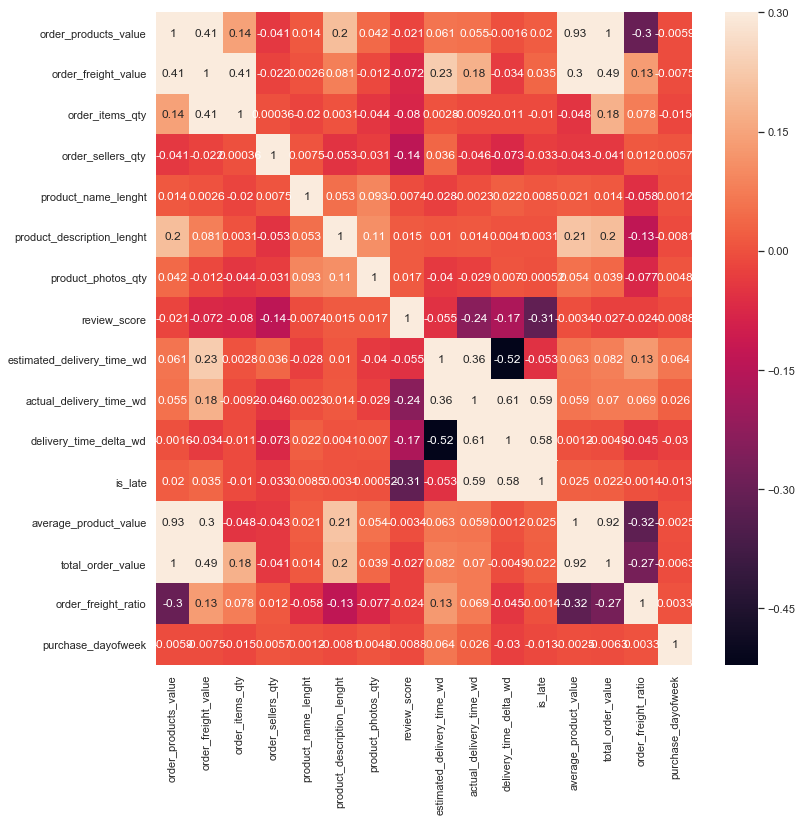

In [10]:
sns.set(font_scale=1)
corr = orders_FE1.corr()
#mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    plt.figure(figsize=(12,12))
    ax = sns.heatmap(corr, vmax=.3, annot=True)

In [11]:
orders_FE1.columns

Index(['order_status', 'order_products_value', 'order_freight_value',
       'order_items_qty', 'order_sellers_qty', 'customer_state',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'review_score',
       'estimated_delivery_time_wd', 'actual_delivery_time_wd',
       'delivery_time_delta_wd', 'is_late', 'average_product_value',
       'total_order_value', 'order_freight_ratio', 'purchase_dayofweek'],
      dtype='object')

In [19]:
orders_FE1['order_status'].value_counts().count()

7

In [45]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
orders_FE1['order_status'] = lb_make.fit_transform(orders_FE1['order_status'])
orders_FE1['product_category_name'] = lb_make.fit_transform(orders_FE1['product_category_name'])
orders_FE1['customer_state'] = lb_make.fit_transform(orders_FE1['customer_state'])
orders_FE1['is_late'] = lb_make.fit_transform(orders_FE1['is_late'])

orders_FE1.columns#Results in appending a new column to df

Index(['order_status', 'order_products_value', 'order_freight_value',
       'order_items_qty', 'order_sellers_qty', 'customer_state',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'review_score',
       'estimated_delivery_time_wd', 'actual_delivery_time_wd',
       'delivery_time_delta_wd', 'is_late', 'average_product_value',
       'total_order_value', 'order_freight_ratio', 'purchase_dayofweek'],
      dtype='object')

In [48]:
from sklearn.preprocessing import StandardScaler
numerical = ['order_status', 'order_products_value', 'order_freight_value',
       'order_items_qty', 'order_sellers_qty', 'customer_state',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'review_score',
       'estimated_delivery_time_wd', 'actual_delivery_time_wd',
       'delivery_time_delta_wd', 'is_late', 'average_product_value',
       'total_order_value', 'order_freight_ratio', 'purchase_dayofweek']
X = orders_FE1.loc[:,numerical]
st_scaler  = StandardScaler().fit(X.values)
Xscaled = st_scaler.transform(X.values).reshape(X.shape)
orders_FE1 = pd.DataFrame(Xscaled,columns=numerical)

In [49]:
from sklearn.model_selection import StratifiedShuffleSplit
# Stratified Split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(orders_FE1, orders_FE1['review_score']):
    train_set = orders_FE1.loc[train_index]
    test_set = orders_FE1.loc[test_index]

In [51]:
train_set.shape

(80000, 19)

In [52]:
orders_features_train = train_set.drop('review_score', axis=1)
orders_features_test = test_set.drop('review_score', axis=1)

In [53]:
orders_features_train.shape, orders_features_test.shape

((80000, 18), (20000, 18))

In [54]:
target_variable_train = train_set['review_score'].copy()
target_variable_test = test_set['review_score'].copy()

In [55]:
len(target_variable_train), len(target_variable_test)

(80000, 20000)

In [60]:
orders_features_train.head()

,order_status,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,customer_state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,estimated_delivery_time_wd,actual_delivery_time_wd,delivery_time_delta_wd,is_late,average_product_value,total_order_value,order_freight_ratio,purchase_dayofweek
40939,-0.117041,-0.509087,-0.767075,-0.217973,1.210890,0.909628,-1.477154,0.607574,-0.246505,-0.730555,0.782110,-0.505479,-1.123511,-0.282071,-0.514903,-0.562107,-0.307112,-0.392834
61790,-0.117041,-0.529614,-0.380282,-0.217973,-0.199894,-1.211597,1.248939,0.410322,-0.094713,-0.158960,-0.676352,-0.205005,0.385322,-0.282071,-0.537545,-0.543617,0.825807,1.131158
8241,-0.117041,-0.355594,0.352484,-0.217973,-0.199894,-0.504522,0.086998,0.804827,-0.620725,-0.158960,1.106213,0.245707,-0.712011,-0.282071,-0.345599,-0.305112,0.616000,1.131158
24634,-0.117041,0.070349,0.298224,-0.217973,-0.199894,-1.211597,0.891419,1.396585,0.993379,0.412634,0.133905,0.245707,0.110988,-0.282071,0.124217,0.096614,-0.365284,-0.392834
33526,-0.117041,-0.355594,0.175266,-0.217973,-0.199894,-0.080277,0.399828,-0.773194,0.030027,-0.730555,-0.190198,-0.205005,-0.026178,-0.282071,-0.345599,-0.322572,0.412853,0.623160


In [59]:
target_variable_test.shape

(20000,)

In [61]:
# Machine learning library/functions
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
np.random.seed(42)
from sklearn import linear_model
import sklearn.linear_model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# Additional librariers used for modeling and evaluation
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.model_selection import cross_val_score
from sklearn.grid_search import GridSearchCV

C:\Users\R2D2\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [63]:
Xtrain= orders_features_train
Ytrain = target_variable_train

Xtest= orders_features_test
Ytest= target_variable_test


In [64]:
lin_reg=LinearRegression()
lin_reg.fit(Xtrain,Ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [65]:
lin_reg.score(Xtrain,Ytrain)

0.17932308638455952

In [66]:
rf_reg=RandomForestRegressor()
rf_reg.fit(Xtrain,Ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [67]:
rf_reg.score(Xtrain,Ytrain)

0.8495417191392389

In [68]:
rf_reg.score(Xtest,Ytest)

0.17821365866418581

In [71]:
parameters = {"n_estimators": [5,10,20,40,60],"max_features":['auto','sqrt','log2'],"max_depth":[10,15,20]}
#rf1_reg = RandomForestRegressor(n_jobs=-1)

In [72]:
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = parameters, 
                          cv = 3, n_jobs = -1, verbose = 2)


In [73]:
grid_search.fit(Xtrain, Ytrain)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  8.4min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [5, 10, 20, 40, 60], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=2)

In [74]:
grid_search.best_params_

{'max_depth': 20, 'max_features': 'log2', 'n_estimators': 60}

In [75]:
rf1_reg= grid_search.best_estimator_

In [76]:
score=rf1_reg.score(Xtest,Ytest)

In [77]:
score

0.27512209645571817

In [79]:
from sklearn.model_selection import RandomizedSearchCV
parameters1 = {"n_estimators": [5,10,20,40,60],"max_features":['auto','sqrt','log2'],"max_depth":[10,15,20]}
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = parameters1, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(Xtrain, Ytrain)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.7min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [5, 10, 20, 40, 60], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 15, 20]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [80]:
rf_random.best_params_

{'n_estimators': 60, 'max_features': 'sqrt', 'max_depth': 20}

In [81]:
rf2_reg= rf_random.best_estimator_
rf2_reg.score(Xtest,Ytest)

0.27629792308448986